In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pycbc.types import FrequencySeries, TimeSeries
from pycbc.noise import noise_from_psd
from pycbc.waveform import get_td_waveform
from pycbc.psd import aLIGOZeroDetHighPower
from pycbc.detector import Detector
from scipy.stats import norm, skew, kurtosis

# 参数设置
total_segments = 50000
noise_segments = 40000  # 仅包含噪声的段数
signal_segments = total_segments - noise_segments  # 包含chirp信号的段数
sampling_rate = 4096  # 采样率（每秒采样数）
duration = 1  # 每段数据的持续时间（秒）
delta_t = 1 / sampling_rate  # 每个采样点的时间间隔
low_freq_cutoff = 20  # 低频截止频率（Hz）

In [2]:
# Step 1: 生成高斯白噪声数据
noise_data = np.random.normal(0, 1, noise_segments)

# Step 2: 生成简化的 chirp 信号
chirp_signal, _ = get_td_waveform(
    approximant="IMRPhenomD", 
    mass1=10, 
    mass2=10, 
    delta_t=delta_t, 
    f_lower=20
)

# 简化 chirp 信号为一个点：取最大幅值
chirp_peak = np.max(np.abs(chirp_signal.numpy()))  # 获取 chirp 信号的最大幅值
signal_data = np.random.normal(0, 1, signal_segments) + chirp_peak  # 叠加 chirp 信号到部分段

# Step 3: 混合包含信号和仅噪声的数据段
combined_data = np.concatenate([noise_data, signal_data])
np.random.shuffle(combined_data)  # 随机混合数据

In [3]:
# Step 4: 生成自定义平坦 PSD，以便噪声模拟和频率匹配
psd_length = int(sampling_rate / 2 + 1)
psd = np.ones(psd_length)
psd = FrequencySeries(psd, delta_f=1.0 / duration)

# Step 5: 使用探测器的数据生成噪声，并注入引力波信号
data_length = int(duration * sampling_rate)  # 每段数据的点数
detector1 = Detector("H1")
detector2 = Detector("L1")

# 从两个探测器数据生成噪声
detector1_data = noise_from_psd(data_length, delta_t, psd)
detector2_data = noise_from_psd(data_length, delta_t, psd)

# 将 chirp 信号转换为与 detector 数据匹配的 TimeSeries，并设置 epoch 为 0
chirp_signal_ts = TimeSeries(chirp_signal[:data_length], delta_t=delta_t, epoch=0)

# 直接叠加 chirp 信号到探测器噪声数据中，模拟信号注入
detector1_signal = detector1_data + chirp_signal_ts
detector2_signal = detector2_data + chirp_signal_ts  # 对探测器2也注入信号

In [4]:
# Step 6: 计算交叉相关
# 转换到频域
detector1_freq = detector1_signal.to_frequencyseries()
detector2_freq = detector2_signal.to_frequencyseries()

# 计算频域中的交叉谱，并进行归一化
cross_spectrum = (detector1_freq * detector2_freq.conj()) / (psd * psd)
cross_spectrum = np.array(cross_spectrum)

# 计算交叉相关的频率积分（作为充分统计量之一）
cross_corr_integral = np.sum(np.real(cross_spectrum)) / len(cross_spectrum)

# 计算交叉相关的方差（作为充分统计量之一）
cross_corr_variance = np.var(np.real(cross_spectrum))

# Step 7: 使用高阶累积量计算偏度和峰度（基于原始数据段）
# 使用信号数据段计算偏度和峰度（基于三阶和四阶累积量）
signal_data_mean = np.mean(signal_data)
signal_data_std = np.std(signal_data)

# 三阶累积量（用于计算偏度）
signal_data_skewness = np.sum(((signal_data - signal_data_mean) / signal_data_std) ** 3) / len(signal_data)

# 四阶累积量（用于计算峰度）
signal_data_kurtosis = np.sum(((signal_data - signal_data_mean) / signal_data_std) ** 4) / len(signal_data) - 3

# 使用 duty cycle 调整偏度和峰度
duty_cycle = signal_segments / total_segments
signal_data_skewness *= duty_cycle
signal_data_kurtosis *= duty_cycle

# 输出偏度和峰度结果
print(f"Skewness of Signal Data: {signal_data_skewness}")
print(f"Kurtosis of Signal Data: {signal_data_kurtosis}")

Skewness of Signal Data: -0.0025372810908076216
Kurtosis of Signal Data: -0.001195850686436817


In [5]:
# Step 8: 改进最大似然函数并计算（基于文献中的方法）
def likelihood_max_likelihood(cross_corr_integral, cross_corr_variance, skewness, kurtosis, detector1_signal, detector2_signal):
    # 使用多个探测器的信号构造联合似然函数
    # 增加非高斯噪声的检测能力
    gaussian_likelihood1 = norm.pdf(np.mean(detector1_signal), loc=0, scale=np.std(detector1_signal))
    gaussian_likelihood2 = norm.pdf(np.mean(detector2_signal), loc=0, scale=np.std(detector2_signal))
    combined_gaussian_likelihood = gaussian_likelihood1 * gaussian_likelihood2
    
    skew_term = np.exp(-0.5 * skewness ** 2 / (cross_corr_variance + 1e-6))
    kurtosis_term = np.exp(-0.5 * kurtosis ** 2 / (cross_corr_variance + 1e-6))
    return combined_gaussian_likelihood * skew_term * kurtosis_term

# 计算最大似然值
likelihood_value = likelihood_max_likelihood(cross_corr_integral, cross_corr_variance, signal_data_skewness, signal_data_kurtosis, detector1_signal, detector2_signal)
print(f"Maximum Likelihood Value: {likelihood_value}")

# Step 9: 滑动窗口检测交叉相关
# 使用滑动窗口方法对交叉相关进行局部评估
window_size = 1024  # 滑动窗口大小
step_size = 512  # 窗口步长
cross_corr_snr_values = []

for start in range(0, len(cross_spectrum) - window_size + 1, step_size):
    window = cross_spectrum[start:start + window_size]
    window_mean = np.sum(np.real(window)) / len(window)
    window_variance = np.var(np.real(window))
    window_snr = window_mean / (np.sqrt(window_variance) + 1e-6)
    cross_corr_snr_values.append(window_snr)

max_snr = max(cross_corr_snr_values)
print(f"Maximum SNR from Sliding Window: {max_snr}")

Maximum Likelihood Value: 7.697084698153926e-05
Maximum SNR from Sliding Window: 0.015274930442792945


In [6]:
# Step 10: 阈值检测并提取信号（改进版）
# 设置信噪比阈值（降低阈值以提高灵敏度）
snr_threshold = 1.5  # 降低阈值以捕获更多可能的信号

# 检测信号
if max_snr > snr_threshold:
    print("Signal detected with significant SNR using sliding window.")
    detected_signal = max_snr  # 可以进一步提取信号
else:
    print("No significant signal detected using sliding window.")
    detected_signal = None

# Step 11: 贝叶斯分析 - 使用充分统计量计算后验概率分布（改进版）
# 假设观测的加权交叉相关频率积分为高斯分布
x = np.linspace(-5, 5, 1000)  # 根据 cross_corr_variance 的范围调整
posterior_prob = norm.pdf(x, loc=cross_corr_integral, scale=np.sqrt(cross_corr_variance + 1e-6))

# 使用一个合适的权重调整后验概率
weight = max_snr / (snr_threshold + 1e-6)
if weight > 1:
    weight = 1

posterior_prob_adjusted = posterior_prob * weight

# 归一化后验概率
posterior_prob_adjusted /= np.sum(posterior_prob_adjusted) * (x[1] - x[0])

No significant signal detected using sliding window.


Average Cross-correlation Integral: -0.0009209679478396137


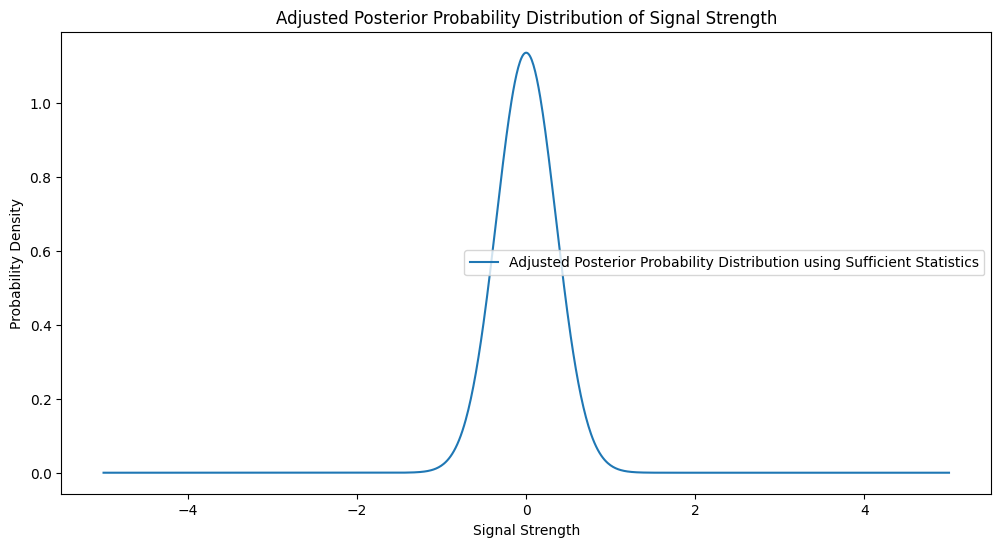

In [7]:
# Step 12: 分段处理和平均
# 将数据分为多个小段，并分别计算交叉相关的平均值以减少随机噪声的影响
num_subsegments = 10
subsegment_length = len(cross_spectrum) // num_subsegments
cross_corr_means = []

for i in range(num_subsegments):
    subsegment = cross_spectrum[i * subsegment_length: (i + 1) * subsegment_length]
    cross_corr_means.append(np.sum(np.real(subsegment)) / len(subsegment))

average_cross_corr = np.mean(cross_corr_means)
print(f"Average Cross-correlation Integral: {average_cross_corr}")

# Step 13: 可视化后验概率分布
# 已经计算的后验概率分布可视化
plt.figure(figsize=(12, 6))
plt.plot(x, posterior_prob_adjusted, label="Adjusted Posterior Probability Distribution using Sufficient Statistics")
plt.xlabel("Signal Strength")
plt.ylabel("Probability Density")
plt.title("Adjusted Posterior Probability Distribution of Signal Strength")
plt.legend()
plt.show()

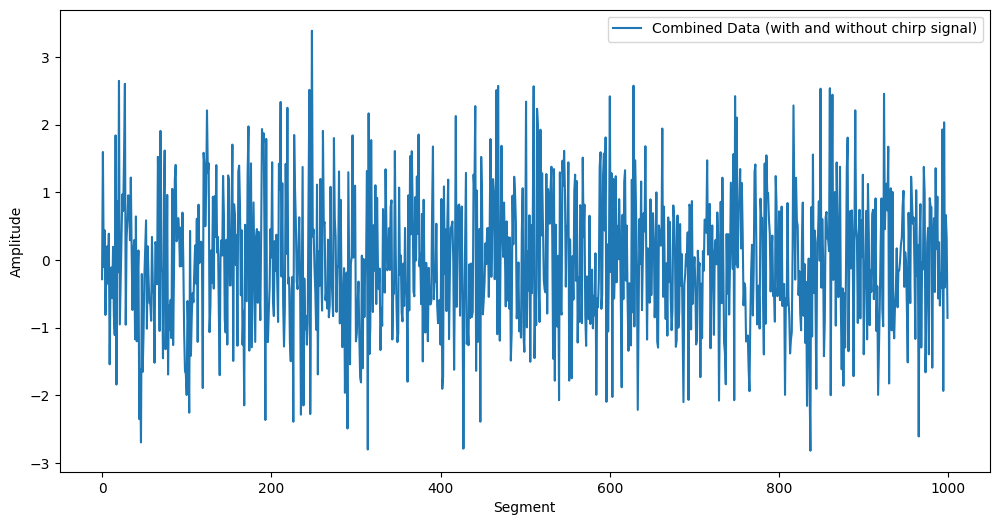

In [8]:
# Step 14: 绘制原始数据和交叉相关结果
# 原始数据
plt.figure(figsize=(12, 6))
plt.plot(combined_data[:1000], label="Combined Data (with and without chirp signal)")
plt.xlabel("Segment")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

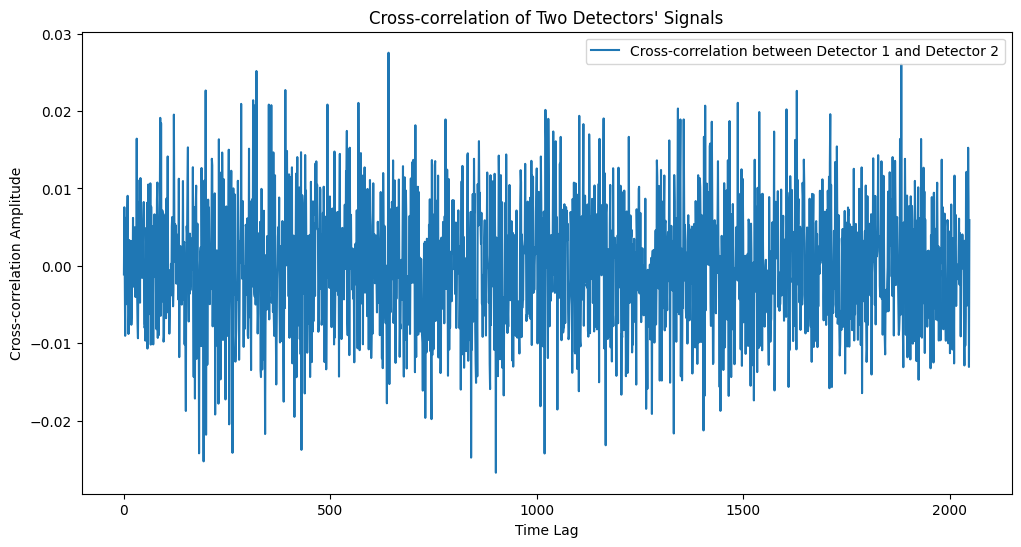

In [9]:
# cross_correlation结果
cross_correlation = np.real(np.fft.ifft(cross_spectrum))
plt.figure(figsize=(12, 6))
plt.plot(cross_correlation, label="Cross-correlation between Detector 1 and Detector 2")
plt.xlabel("Time Lag")
plt.ylabel("Cross-correlation Amplitude")
plt.legend()
plt.title("Cross-correlation of Two Detectors' Signals")
plt.show()